In [100]:
import json
import pandas as pd
import sys

sys.path.append("../")

from config import DATA_DIR
from graph_types.graph import Graph
import matplotlib.pyplot as plt

graph_name = "prime"

In [118]:
logs_dir = DATA_DIR / f"experiments/{graph_name}/subgraph_explorer"
json_files = sorted([f for f in logs_dir.glob("*.json")], key=lambda x: x.stat().st_ctime)

data = []

for json_file in json_files:
    with open(json_file, "r") as f:
        log_data = json.load(f)

    # Extract key information from each log entry
    record = {
        "file_id": int(json_file.stem),
        "question": log_data.get("question", ""),
        "all_nodes": log_data.get("all_nodes", []),
        "message_histories": log_data.get("message_histories", ""),
        "starting_nodes_indices": log_data.get("starting_nodes_indices", []),
        "agent_answer_indices": log_data.get("agent_answer_indices", []),
        "answer_indices": log_data.get("answer_indices", []),
    }

    data.append(record)

df = pd.DataFrame(data).reset_index(drop=True)# .sort_values(by="file_id").reset_index(drop=True)

df["recall@all"] = df.apply(
    lambda row: len(set(row["answer_indices"]).intersection(set(row["agent_answer_indices"])))
    / len(set(row["answer_indices"])),
    axis=1,
)
df["hit@1"] = df.apply(
    lambda row: (
        row["agent_answer_indices"][0] in row["answer_indices"]
        if row["agent_answer_indices"]
        else False
    ),
    axis=1,
)
df["hit@5"] = df.apply(
    lambda row: len(set(row["answer_indices"]).intersection(set(row["agent_answer_indices"][:5])))
    > 0,
    axis=1,
)
df["hit@10"] = df.apply(
    lambda row: len(set(row["answer_indices"]).intersection(set(row["agent_answer_indices"][:10])))
    > 0,
    axis=1,
)
df["recall@10"] = df.apply(
    lambda row: len(set(row["answer_indices"]).intersection(set(row["agent_answer_indices"][:10])))
    / len(set(row["answer_indices"])),
    axis=1,
)
df["recall@20"] = df.apply(
    lambda row: len(set(row["answer_indices"]).intersection(set(row["agent_answer_indices"][:20])))
    / len(set(row["answer_indices"])),
    axis=1,
)

[
    ("n", len(df)),
    ("Hit@1", float(round(df["hit@1"].mean(), 3))),
    ("Hit@5", float(round(df["hit@5"].mean(), 3))),
    ("Recall@10", float(round(df["recall@10"].mean(), 3))),
    ("Recall@20", float(round(df["recall@20"].mean(), 3))),
    ("Recall@all", float(round(df["recall@all"].mean(), 3))),
]

[('n', 100),
 ('Hit@1', 0.32),
 ('Hit@5', 0.54),
 ('Recall@10', 0.535),
 ('Recall@20', 0.566),
 ('Recall@all', 0.569)]

### Was the answer reachable? Was the answer mentioned?

In [102]:
try:
    graph
except NameError:
    graph= Graph.load(graph_name)

(array([0, 1]), [Text(0, 0, 'non-reachable'), Text(1, 0, 'reachable')])

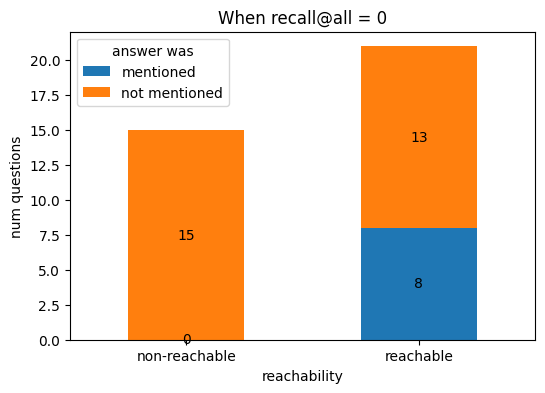

In [103]:
df["reachable_nodes"] = df["starting_nodes_indices"].apply(
    lambda starting_nodes_indices: [
        j
        for i in starting_nodes_indices
        for j in list(graph.get_khop_idx(graph.get_node_by_index(i), 2))
    ]
)

df["was_answer_reachable"] = df.apply(
    lambda row: set(row["answer_indices"]).issubset(row["reachable_nodes"]), axis=1
)

df["answer_names"] = df["answer_indices"].apply(
    lambda x: [graph.get_node_by_index(i).name for i in x]
)
df["was_answer_mentioned"] = df.apply(
    lambda row: all([name.lower() in str(row["message_histories"]).lower() for name in row["answer_names"]]), axis=1
)

# Filter and create crosstab
df0 = df[df["recall@all"] == 0]
ct = pd.crosstab(
    df0["was_answer_reachable"].map({True: "reachable", False: "non-reachable"}),
    df0["was_answer_mentioned"].map({True: "mentioned", False: "not mentioned"}),
)

# Plot stacked bar
ax = ct.plot(kind="bar", stacked=True, figsize=(6, 4))

# Add count labels
for container in ax.containers:
    ax.bar_label(container, label_type="center")

ax.set_title("When recall@all = 0")
ax.set_ylabel("num questions")
ax.legend(title="answer was")
ax.set_xlabel("reachability")
plt.xticks(rotation=0)

### How mant answers did the agent submit?

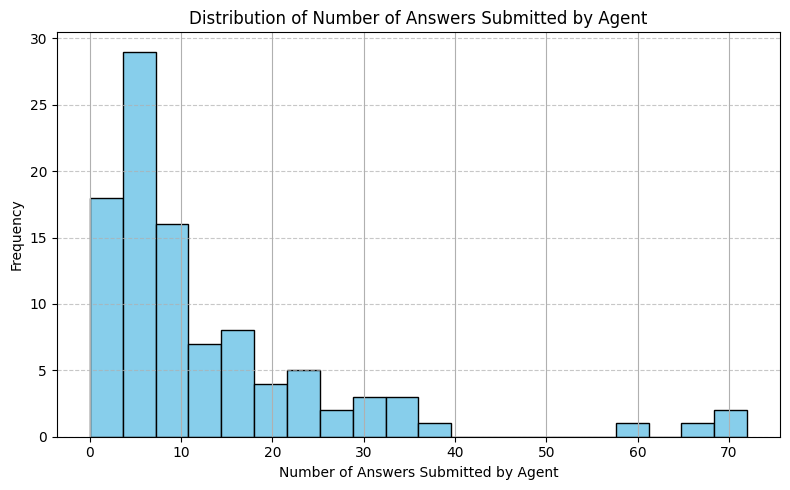

In [104]:
plt.figure(figsize=(8, 5))
df['agent_answer_indices'].apply(len).hist(bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Number of Answers Submitted by Agent')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Answers Submitted by Agent')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### What's the difference between the good and the bad conversations?

In [105]:
df['recall@20'].value_counts()

recall@20
1.000000    49
0.000000    36
0.500000     4
0.666667     2
0.333333     2
0.571429     1
0.777778     1
0.538462     1
0.600000     1
0.125000     1
0.882353     1
0.062500     1
Name: count, dtype: int64

In [106]:
df_recall_1 = df[df['recall@20'] == 1]
df_recall_0 = df[df['recall@20'] == 0]

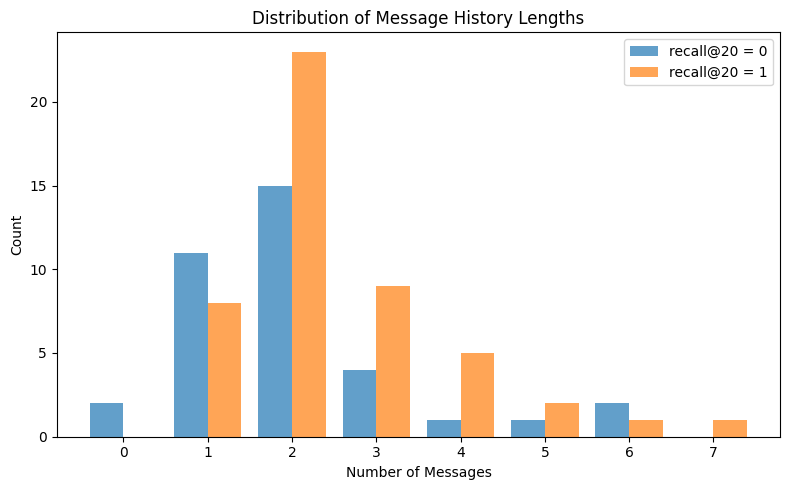

In [107]:
plt.figure(figsize=(8, 5))
lengths_0 = df_recall_0["message_histories"].apply(len)
lengths_1 = df_recall_1["message_histories"].apply(len)

counts_0 = lengths_0.value_counts().sort_index()
counts_1 = lengths_1.value_counts().sort_index()

bar_width = 0.4
indices = sorted(set(counts_0.index).union(counts_1.index))
indices = list(indices)
x = range(len(indices))

plt.bar([i - bar_width/2 for i in x], [counts_0.get(idx, 0) for idx in indices], 
    width=bar_width, alpha=0.7, label="recall@20 = 0")
plt.bar([i + bar_width/2 for i in x], [counts_1.get(idx, 0) for idx in indices], 
    width=bar_width, alpha=0.7, label="recall@20 = 1")

plt.xlabel("Number of Messages")
plt.ylabel("Count")
plt.title("Distribution of Message History Lengths")
plt.xticks(x, indices)
plt.legend()
plt.tight_layout()
plt.show()

In [108]:
conversations_w_recall_1 = []
for set_of_conversations_w_recall_1 in df_recall_1["message_histories"].tolist():
    for conversation in set_of_conversations_w_recall_1:
        conversations_w_recall_1.append(conversation)

conversations_w_recall_0 = []
for set_of_conversations_w_recall_0 in df_recall_0["message_histories"].tolist():
    for conversation in set_of_conversations_w_recall_0:
        conversations_w_recall_0.append(conversation)

In [109]:
def parse_conversation(conversation):
    """Parse conversation data and return readable formatted string"""
    if isinstance(conversation, str):
        try:
            conversation = eval(conversation)
        except:
            return "Error: Could not parse conversation data"
    
    output = []
    output.append("=" * 60)
    output.append("CONVERSATION ANALYSIS")
    output.append("=" * 60)
    
    # Summary
    total = len(conversation)
    user_count = sum(1 for msg in conversation if msg['role'] == 'user')
    assistant_count = sum(1 for msg in conversation if msg['role'] == 'assistant')
    tool_count = sum(1 for msg in conversation if msg['role'] == 'tool')
    
    output.append(f"Total Messages: {total}")
    output.append(f"User: {user_count}, Assistant: {assistant_count}, Tool: {tool_count}")
    output.append("")
    
    # Messages
    for i, message in enumerate(conversation):
        output.append(f"[{i + 1}] {message['role'].upper()}")
        output.append("-" * 30)
        
        if message.get('content'):
            output.append(f"Content: {message['content']}")
        
        if 'tool_calls' in message:
            output.append("Tool Calls:")
            for tool_call in message['tool_calls']:
                output.append(f"  • Function: {tool_call['function']['name']}")
                output.append(f"    ID: {tool_call['id']}")
                if tool_call['function']['arguments']:
                    args = json.loads(tool_call['function']['arguments'])
                    output.append(f"    Args: {args}")
        
        if 'tool_call_id' in message:
            output.append(f"Response to: {message['tool_call_id']}")
        
        output.append("")
    
    return "\n".join(output)

In [110]:
parsed_conversations_w_recall_0 = [
    parse_conversation(conversation) for conversation in conversations_w_recall_0
]
parsed_conversations_w_recall_1 = [
    parse_conversation(conversation) for conversation in conversations_w_recall_1
]

In [111]:
prompt = "Please analyze the following conversation data and provide insights."
prompt += '\n'
prompt += "Set 0 of conversations"
prompt += '\n'
prompt += "\n".join(parsed_conversations_w_recall_0[:40])
prompt += '\n\n'
prompt += "Set 1 of conversations"
prompt += '\n'
prompt += "\n".join(parsed_conversations_w_recall_1[:40])
prompt += '\n\n'
prompt += "Can you explain if you find any differences between how the two sets?"

In [112]:
print(prompt)

Please analyze the following conversation data and provide insights.
Set 0 of conversations
CONVERSATION ANALYSIS
Total Messages: 21
User: 1, Assistant: 10, Tool: 10

[1] USER
------------------------------
Content: Question: Which medications, designed to target genes or proteins associated with the transport of long-chain fatty acids, enhance the duration of drug presence on the ocular surface?

You are starting your exploration at node: **long chain fatty acids, defect in transport of**

## Your Mission
Find all nodes in this knowledge graph that answer the given question. You have been placed at this starting node because it's strategically relevant to the question.

## Recommended First Steps
1. **Understand your starting point**: Use `search_in_surroundings(k=1, query="")` to see what's immediately connected to your current node
2. **Identify the answer type**: Based on the question, determine what type of nodes you're looking for (papers, genes, products, etc.)
3. **Begin system

In [113]:
print(parsed_conversations_w_recall_0[29])

CONVERSATION ANALYSIS
Total Messages: 30
User: 1, Assistant: 10, Tool: 19

[1] USER
------------------------------
Content: Question: I'm seeking a gene or protein that shows serine-type endopeptidase activity, participates in the IGF transport and uptake regulation mediated by IGFBPs, and also triggers Factor IX to initiate thrombin generation and fibrin clotting without Factor XI involvement.

You are starting your exploration at node: **Formation of Fibrin Clot (Clotting Cascade)**

## Your Mission
Find all nodes in this knowledge graph that answer the given question. You have been placed at this starting node because it's strategically relevant to the question.

## Recommended First Steps
1. **Understand your starting point**: Use `search_in_surroundings(k=1, query="")` to see what's immediately connected to your current node
2. **Identify the answer type**: Based on the question, determine what type of nodes you're looking for (papers, genes, products, etc.)
3. **Begin systematic 

In [114]:
for idx, row in df_recall_0[['question', 'answer_names']].iterrows():
    print(f"Question: {row['question']}")
    print(f"Answer Names: {row['answer_names']}")
    print("-" * 40)

Question: Which medications, designed to target genes or proteins associated with the transport of long-chain fatty acids, enhance the duration of drug presence on the ocular surface?
Answer Names: ['Carboxymethylcellulose']
----------------------------------------
Question: Can you supply a list of genes and proteins involved in Wolf-Hirschhorn syndrome that also contribute to skeletal development processes?
Answer Names: ['MSX1']
----------------------------------------
Question: Identify genes or proteins that exhibit interaction with microsomal triglyceride transfer protein (MTTP) and are concurrently linked to a mutually shared disease.
Answer Names: ['APOB']
----------------------------------------
Question: Search for diseases not treated by any drugs that are linked to abnormalities of the falx cerebri.
Answer Names: ['hydranencephaly (disease)']
----------------------------------------
Question: Could you assist in identifying a hereditary neurological disease that causes nigh